# Exploratory Data Analysis

Nesse notebook, é conduzida uma análise exploratória de dados a fim de analisar a distribuição individual das variáveis e suas interrelações a fim de extrair insights para a etapa de modelagem preditiva. 

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from statsmodels.distributions.empirical_distribution import ECDF  # função densidade acumulada empírica

In [41]:
%matplotlib inline

In [129]:
# definindo paleta de cores para variável resposta 
# (para manter a consistência e facilitar a interpretação em diferentes gráficos)
cores = {
    'bom':'tab:blue',
    'ruim':'firebrick'
}

## importando dataset

In [3]:
datapath = Path('../data')

with open(f'{datapath}/data.pickle', 'rb') as file:
    data = pickle.load(file)

## Analisando variável resposta `cred_score`

Relembrando...

```bash
    1 = bom
    2 = ruim
```

In [4]:
data['cred_score'].value_counts()

1    700
2    300
Name: cred_score, dtype: int64

Nota-se um desbalanceamento da amostra, i.e., score de crédito ruim (2) são mais raros que scores bons (1), na proporção 30%/70%, respectivamente. 

<font color='red'>**OBS:**</font> esse fator deve ser considerado na análise preditiva. Se possível, ajustar tal desbalanceando atribuindo maior peso aos scores ruins (classe mais rara).

## descrevendo features numéricas

In [5]:
data.describe()

,duration,cred_amount,installment,resid_since,age,n_creds,n_liable_people
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


1. Nota-se que as variáveis numéricas apresentam unidades distintas. Isso não é um problema para *Decision Trees*, mas devem ser padronizadas antes de se estimar um modelo linear.

2. Há uma leve assimetria em suas distribuições (mediana != média) para a maioria delas. Esse fato será mais explorado graficamente.

3. A variável cred_amount pode apresentar *outlier* (máx. está muito acima do P75).

<br>

A distribuição individual dessas variáveis também é explorada visualmente a seguir:

In [6]:
num_vars = [f for f in data.columns if data[f].dtype == 'int']

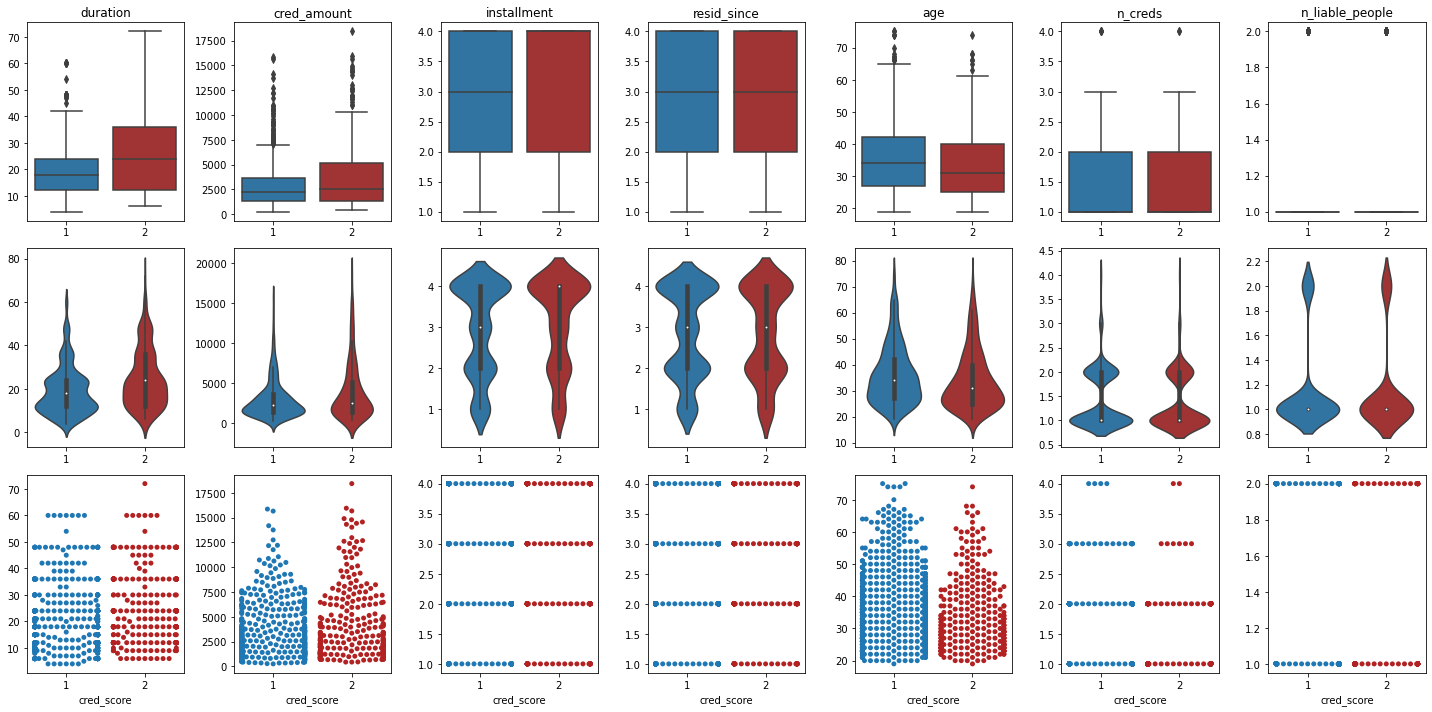

In [133]:
%%capture --no-display
# ocultando warnings do swarmplot

fig, ax = plt.subplots(3, len(num_vars), figsize=(20,10))

for i in range(len(num_vars)):
    sns.boxplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[0,i])
    sns.violinplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[1,i])
    sns.swarmplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[2,i])
    
    # ajustando labels
    ax[0,i].set_ylabel('')
    ax[1,i].set_ylabel('')
    ax[2,i].set_ylabel('')
    ax[0,i].set_xlabel('')
    ax[1,i].set_xlabel('')
    ax[2,i].set_xlabel('cred_score')
    ax[0,i].set_title(num_vars[i])
    
plt.tight_layout()

Nos boxplots acima, notamos os seguintes padrões:

- **duration:** indivíduos com escore "ruim" estão mais dispersos entre diferentes durações de empréstimo. Além da maior dispersão, estes tendem a tomar empréstimos com prazos mais elevados, em média. 
- **cred_amount:** de maneira similar à duração do empréstimo, vemos que indivíduos com escore de crédito ruim tendem a tomar empréstimos de maior valor, em média. 
- **installment:** para esta variável, precisaremos investigar com um pouco mais de cautela. Não se pode inferir muita coisa a partir desse gráfico. 
- **resid_since:** o mesmo se pode dizer para essa variável. Não há diferença aparente entre os dois grupos.
- **age:** aparentemente, indivíduos com escore de crédito ruim aparentam ser mais jovens (menor idade).
- **n_creds:** para os dois grupos, as distribuições parecem idênticas.
- **n_liable_people:** não há diferenças perceptíveis entre os dois grupos.

Além disso, notamos algumas variáveis que, por definição, são discretas e apresentam poucas categorias, como *n_creds* e *n_liable_people*.

Vamos verificar diferenças nas distribuições acumuladas do mesmo conjunto de features. Para isso, vamos estimar a função densidade acumulada empírica com auxílio da library `statsmodels`.

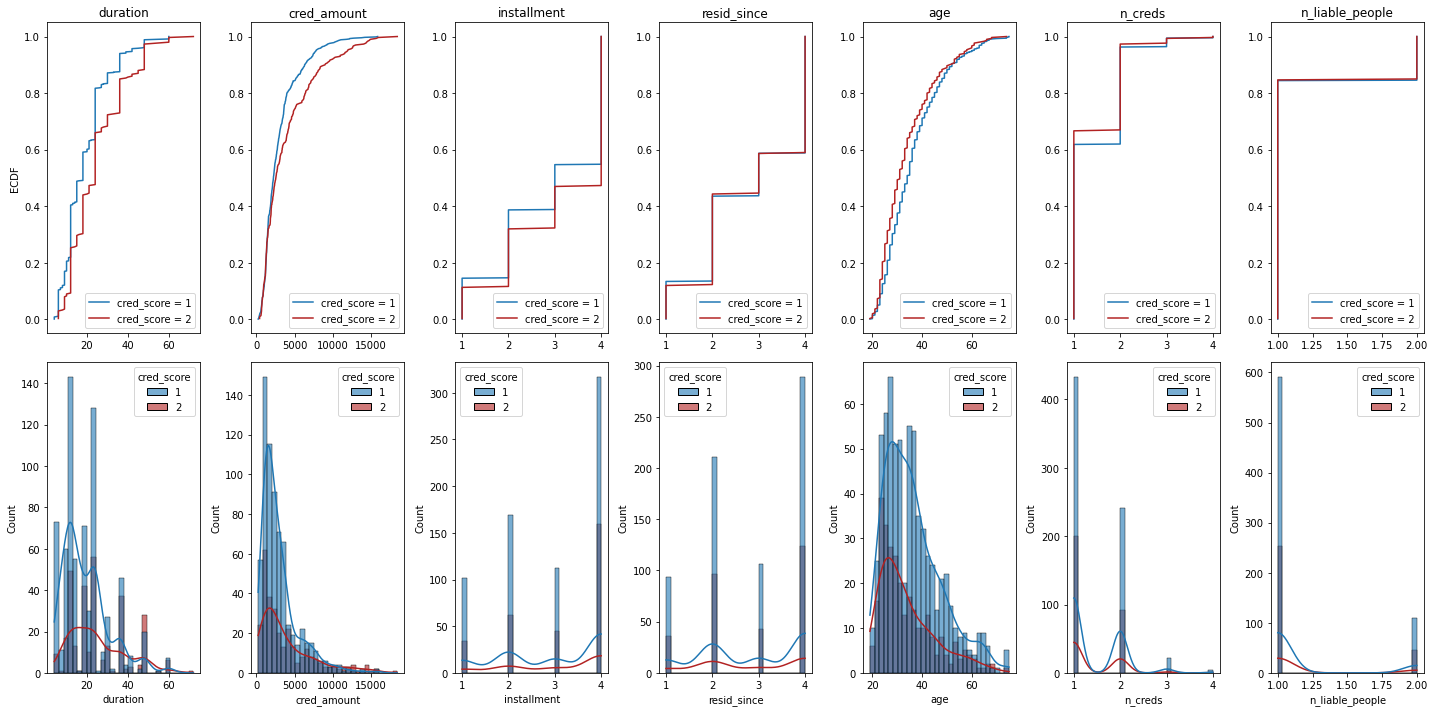

In [135]:
fig, ax = plt.subplots(2, 7, figsize=(20, 10))

for i in range(len(num_vars)):
    feature = num_vars[i]   # selecionando feature
    
    # plotando ECDF
    ecdf1 = ECDF(data[data['cred_score'] == 1][feature])  # score 1
    ecdf2 = ECDF(data[data['cred_score'] == 2][feature])  # score 2
    
    ax[0,i].plot(ecdf1.x, ecdf1.y, color=cores['bom'], label='cred_score = 1')
    ax[0,i].plot(ecdf2.x, ecdf2.y, color=cores['ruim'], label='cred_score = 2')    
    
    # plotando histogramas
    sns.histplot(x=feature, hue='cred_score', data=data, bins=30, alpha=0.6,
                 ax=ax[1,i], kde=True, palette=[cores['bom'], cores['ruim']])
    
    # ajustando labels
    ax[0,i].set_title(feature)
    ax[0,i].legend(loc='lower right')

ax[0,0].set_ylabel('ECDF')
plt.tight_layout()

Analisando as ECDFs (primeira linha), vemos que algumas suspeitas são confirmadas: 

1. Indivíduos de escore ruim (alto risco) tendem a captar crédito com maiores prazos e em maiores quantias monetárias.
2. Adicionalmente, clientes de alto risco tendem a ser ligeiramente mais novos. 
3. Ainda, a variável `installment` revela que clientes com escore ruim são aqueles cujas taxas de parcelamento representam uma maior proporção de sua renda disponível. 

<br>

No entanto, a distribuição individual das variáveis não nos diz muita coisa a respeito do problema em si. Afinal, estamos mais interessados na maneira pela qual estas estão associadas à variável resposta (escore de crédito). 

Assim, vamos investigar a correlação entre estas variáveis e o escore de crédito. 

**Raciocínio:** se separarmos nossa amostra em dois grupos (alto risco e baixo risco), a pergunta que queremos responder é _"O que diferencia o perfil de crédito entre esses dois grupos?, i.e., Qual comportamento observado no conjunto de features pode apontar um maior nível de risco?"_

<br>

### correlação com variável resposta

In [136]:
# sns.pairplot(data[[*num_vars, 'cred_score']], hue='cred_score', palette=['tab:green', 'firebrick'])

,duration,cred_amount,installment,resid_since,age,n_creds,n_liable_people
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000
